In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#Used to save and load models. Speculated to be faster for large models in
#https://machinelearningmastery.com/save-gradient-boosting-models-xgboost-python/
import joblib
#Light#GBM itself
import lightgbm as lgb

Note that classes/tools from sklearn are imported when needed

In [3]:
from IML2018_tools import *

In [4]:
!python --version

Python 3.6.5


In [5]:
!ls

conda_env.list				      qcd_flattened.h5
EDA_and_lightgbm.ipynb			      qcd_test_truth.npy
EDA_and_xgboost.ipynb			      README.md
Evaluate_Models.ipynb			      Test_file_content.ipynb
Feature_Extraction.ipynb		      test_full_Nhardest5.pickle
gs1_2it_ClfOnly_FullSampleTrained.joblib.dat  test_pred_2.npy
gs1_2it.joblib.dat			      test_pred.npy
gs1.joblib.dat				      test_pred_X.npy
gs2.joblib.dat				      train10000_mod.pickle
IML2018_tools.py			      train10000.npy
Prepare_Submission.ipynb		      train_full_Nhardest5.pickle
__pycache__				      ttaus


In [6]:
#train_file_name = 'train10000.npy'
#train_file_name = 'train_full_Nhardest5.pickle'
train_file_name = 'qcd_flattened.h5'

Read in the file properly for different file formats

In [7]:
train_df = loadInputAsDF(train_file_name, n = None)

In [8]:
train_df.shape

(1042167, 90)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042167 entries, 0 to 1042166
Data columns (total 90 columns):
genjet_sd_m              1042167 non-null float32
recojet_pt               1042167 non-null float32
recojet_eta              1042167 non-null float32
recojet_phi              1042167 non-null float32
recojet_m                1042167 non-null float32
recojet_sd_pt            1042167 non-null float32
recojet_sd_eta           1042167 non-null float32
recojet_sd_phi           1042167 non-null float32
recojet_sd_m             1042167 non-null float32
n_constituents           1042167 non-null int32
constituents_pt_0        1042167 non-null float32
constituents_pt_1        1042167 non-null float32
constituents_pt_2        1042167 non-null float32
constituents_pt_3        1042167 non-null float32
constituents_pt_4        1042167 non-null float32
constituents_pt_5        1042167 non-null float32
constituents_pt_6        1042167 non-null float32
constituents_pt_7        1042167 non-nu

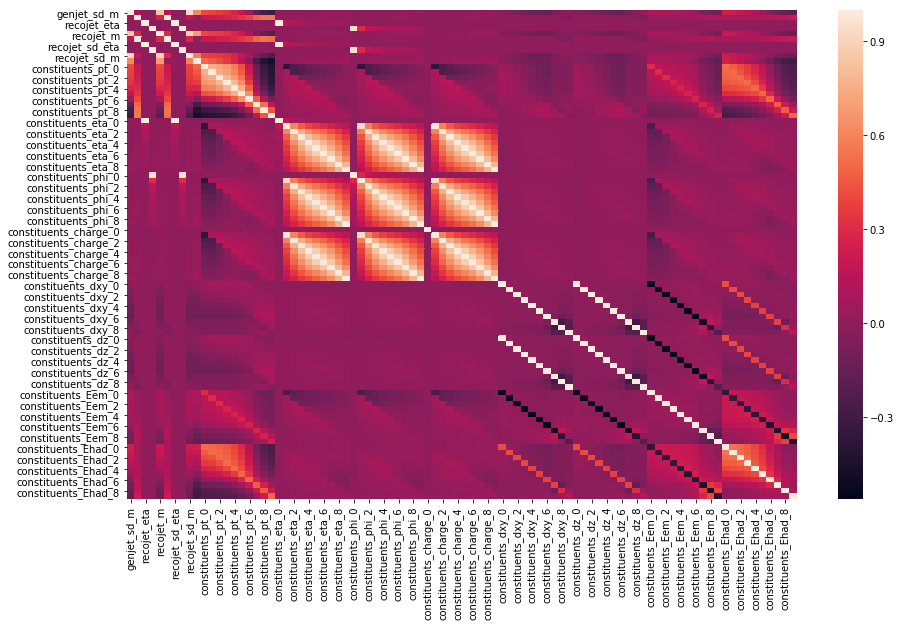

In [10]:
plt.figure(figsize=(15,9))
sns.heatmap(train_df.corr())

## EDA

/home/mlisovyi/anaconda2/envs/iml2018/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


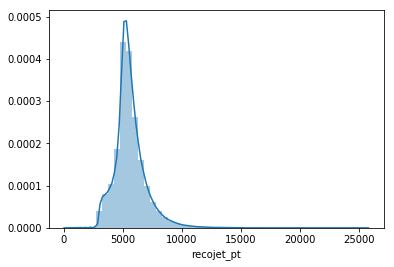

In [11]:
sns.distplot(train_df['recojet_pt'])

In [12]:
#for var in ['recojet_pt', 'recojet_eta', 'recojet_phi', 'recojet_m',
#       'recojet_sd_pt', 'recojet_sd_eta', 'recojet_sd_phi', 'recojet_sd_m',
#       'n_constituents']:
#    print(var)
#    sns.jointplot(x='genjet_sd_m', y=var, data=train_df, kind='hex')

### Feature engineering (done in a dedicated notebook now) and drop some columns

In [13]:
dropColumns(train_df, printColumns=True)

Index(['genjet_sd_m', 'recojet_pt', 'recojet_eta', 'recojet_phi', 'recojet_m',
       'recojet_sd_pt', 'recojet_sd_eta', 'recojet_sd_phi', 'recojet_sd_m',
       'n_constituents', 'constituents_pt_0', 'constituents_pt_1',
       'constituents_pt_2', 'constituents_pt_3', 'constituents_pt_4',
       'constituents_pt_5', 'constituents_pt_6', 'constituents_pt_7',
       'constituents_pt_8', 'constituents_pt_9', 'constituents_eta_0',
       'constituents_eta_1', 'constituents_eta_2', 'constituents_eta_3',
       'constituents_eta_4', 'constituents_eta_5', 'constituents_eta_6',
       'constituents_eta_7', 'constituents_eta_8', 'constituents_eta_9',
       'constituents_phi_0', 'constituents_phi_1', 'constituents_phi_2',
       'constituents_phi_3', 'constituents_phi_4', 'constituents_phi_5',
       'constituents_phi_6', 'constituents_phi_7', 'constituents_phi_8',
       'constituents_phi_9', 'constituents_charge_0', 'constituents_charge_1',
       'constituents_charge_2', 'constituents_char

### Split and normalise

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('genjet_sd_m', axis=1), train_df['genjet_sd_m'] , test_size=0.30, random_state=314)

## Run only if you want to keep jets between 5 and 7 TeV in the test sample

In [16]:
#Xtest5to7 = (X_test['recojet_pt'] > 5000) & (X_test['recojet_pt'] < 7000)

In [17]:
#X_test = X_test[Xtest5to7]
#y_test = y_test[Xtest5to7]

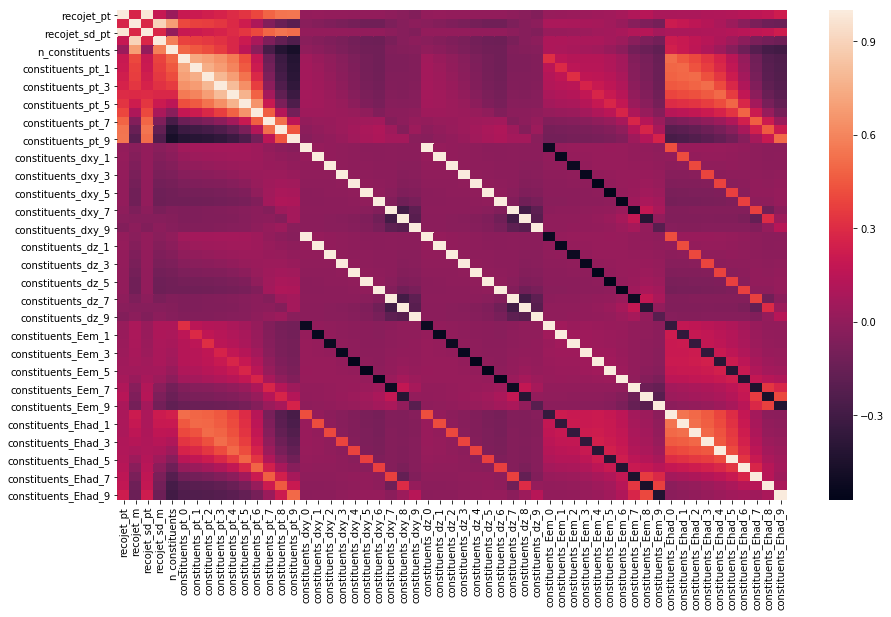

In [17]:
plt.figure(figsize=(15,9))
sns.heatmap(X_train.corr())

In [29]:
from sklearn.decomposition import PCA
pca_trans = PCA()
pca_trans.fit(X_train)
X_train_pca = pca_trans.transform(X_train)
X_test_pca = pca_trans.transform(X_test)

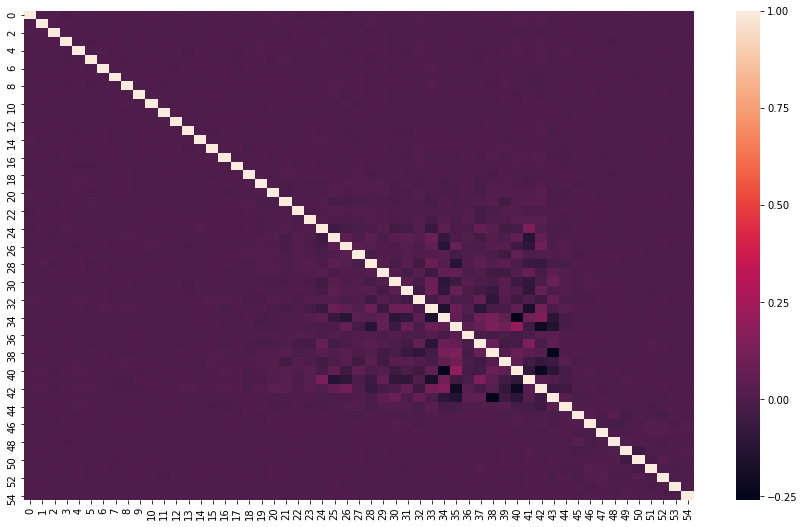

In [30]:
plt.figure(figsize=(15,9))
sns.heatmap(pd.DataFrame(X_test_pca).corr())

# LightGBM regressor

## Build the LightGBM model and define the metric

In [18]:
nEarlyStop = 30

In [19]:
#preliminary parameters. will be fine-tuned in the GridSearch
lgb_params = {'max_depth': 11, 'learning_rate':0.1, 'n_estimators':500,
              'num_leaves': 500, 'colsample_bytree': 0.8,  
              'reg_alpha': 1e-05, 'reg_lambda': 1,
              'silent':1, 'random_state': 314, 'seed': 314, 'n_jobs':4}

In [20]:
clf = lgb.LGBMRegressor(**lgb_params)

In [22]:
clf.set_params(**lgb_params)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
       learning_rate=0.1, max_depth=11, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
       n_jobs=4, num_leaves=500, objective=None, random_state=314,
       reg_alpha=1e-05, reg_lambda=1, seed=314, silent=1, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [ ]:
#clf.set_params(**lgb_params)
clf.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_names=['validation_0', 'validation_1'],
        eval_metric=evaluate_loss_lgb,
        early_stopping_rounds = nEarlyStop,
        verbose=20)

In [ ]:
plotClfPerfEvolution(clf, title='LBGM adjusted towards XGB settings', nEarlyStop=nEarlyStop)
plt.ylim((1.3,2))

In [ ]:
y_pred = clf.predict(X_test)
evaluate_loss(y_test, y_pred)

## GridSearch to determine the optimal parameters

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
from scipy.stats import randint as sp_randint

In [ ]:
from scipy.stats import uniform as sp_uniform

In [ ]:
lgb_params

The next cell is CPU intense! do not try it on the full dataset!!!!!

In [ ]:
param_test_list = [{'max_depth': sp_randint(10, 15),
                    'num_leaves': sp_randint(200, 1000),
                    'min_child_weight': sp_randint(1, 10),
                    'subsample': sp_uniform(loc=0.6, scale=0.4), 
                    'colsample_bytree': sp_uniform(loc=0.6, scale=0.4)},
               {'min_child_weight': sp_randint(10, 1000)}]

In [ ]:
cv_results=[]

In [ ]:
n_iter = [30, 5, 5, 10]
#n_iter = [2, 2, 2, 2]
for i, param_test in enumerate(param_test_list):
    print('============================ ', i, ' =================')
    gs1 = RandomizedSearchCV(estimator=clf, param_distributions=param_test, 
                             n_iter=n_iter[i],
                             scoring=make_scorer(evaluate_loss, greater_is_better=False),
                             cv=3,
                             random_state=314,
                             verbose=True)
    gs1.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_names=['validation_0', 'validation_1'],
            eval_metric=evaluate_loss_lgb,
            early_stopping_rounds=nEarlyStop, 
            verbose=50)
    print(gs1.best_params_)
    print(gs1.best_score_)
    cv_results.append(gs1.cv_results_)
    #clf.set_params(**(gs1.best_params_))

# Here are optimal parameters after hyper-parameter optimisation

In [21]:
lgb_params = {'learning_rate':0.1, 'n_estimators':500, 
              'silent':1, 'random_state': 314, 'seed': 314, 'n_jobs':4, 
              'colsample_bytree': 0.95, 'max_depth': 12, 'min_child_weight': 5, 
                  'num_leaves': 400, 'subsample': 0.95,  
                  'reg_lambda': 1, 'reg_alpha': 0.001}
clf = lgb.LGBMRegressor(**lgb_params)

In [23]:
nEarlyStop=50

clf.fit(X_train, y_train, 
            eval_set=[(X_test, y_test)],
            eval_names=['validation_1'],
            eval_metric=evaluate_loss_lgb,
            early_stopping_rounds=nEarlyStop, 
            verbose=50)

evaluate_loss(y_test, clf.predict(X_test,))

Training until validation scores don't improve for 50 rounds.
[50]	validation_1's l2: 6599.47	validation_1's xxx: 1.68682
[100]	validation_1's l2: 6578.24	validation_1's xxx: 1.51483
Early stopping, best iteration is:
[79]	validation_1's l2: 6572.66	validation_1's xxx: 1.54891


1.5489116386039379

In [26]:
nEarlyStop=50
clf.set_params(**{'objective': 'regression'})

clf.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_names=['validation_0', 'validation_1'],
            eval_metric=evaluate_loss_lgb,
            early_stopping_rounds=nEarlyStop, 
            verbose=50)

evaluate_loss(y_test, clf.predict(X_test))

Training until validation scores don't improve for 50 rounds.
[50]	validation_0's l2: 5499.72	validation_0's xxx: 1.48127	validation_1's l2: 6604.15	validation_1's xxx: 1.51449
[100]	validation_0's l2: 4867.97	validation_0's xxx: 1.32384	validation_1's l2: 6581.17	validation_1's xxx: 1.37444
Early stopping, best iteration is:
[96]	validation_0's l2: 4912.92	validation_0's xxx: 1.32873	validation_1's l2: 6580.97	validation_1's xxx: 1.37721


1.3772146154552871

(1, 2)

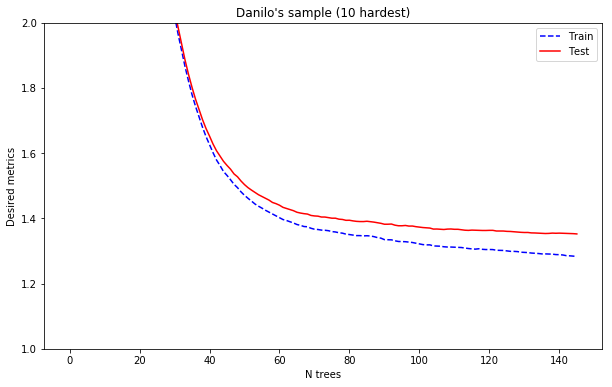

In [33]:
plotClfPerfEvolution(clf, title='Danilo\'s sample (10 hardest)', nEarlyStop=nEarlyStop )
plt.ylim((1,2))

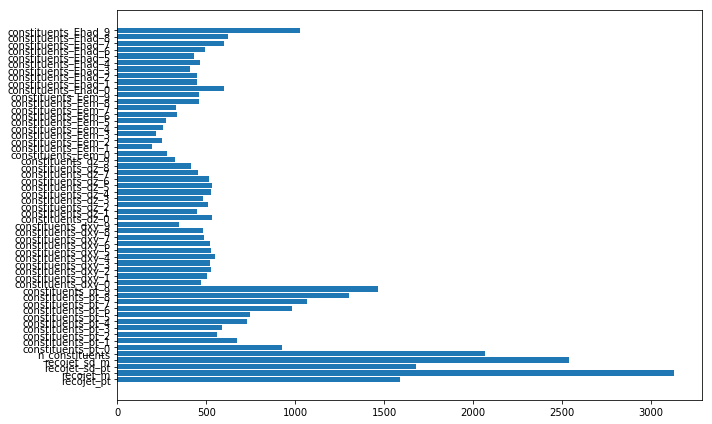

In [34]:
plt.figure(figsize=(10,6))
plt.barh(clf.booster_.feature_name(), clf.booster_.feature_importance())
plt.tight_layout()

# Let's try various non-standard provided metrics

================ regression_l1 =======================
regression_l1
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's l1: 32.5884	validation_0's xxx: 0.644862	validation_1's l1: 34.1552	validation_1's xxx: 0.703003
Early stopping, best iteration is:
[138]	validation_0's l1: 32.1688	validation_0's xxx: 0.623061	validation_1's l1: 34.0734	validation_1's xxx: 0.701219


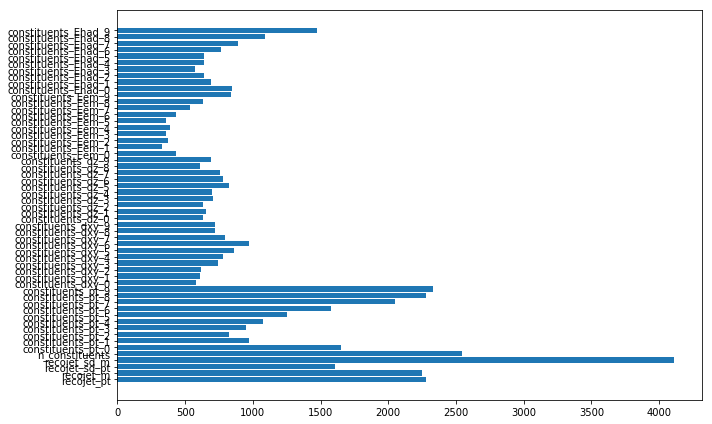

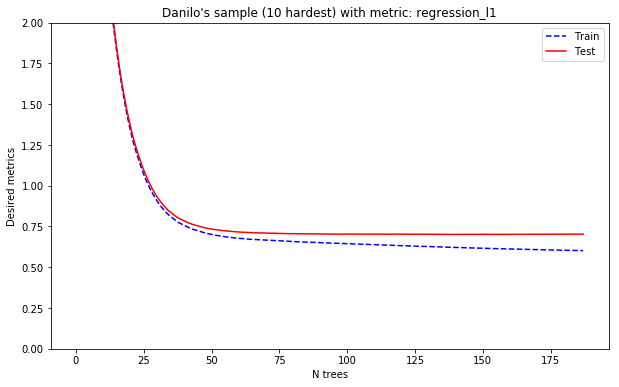

================ mape =======================
mape
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's mape: 0.657132	validation_0's xxx: 1.09924	validation_1's mape: 0.674656	validation_1's xxx: 1.10315
Early stopping, best iteration is:
[96]	validation_0's mape: 0.657357	validation_0's xxx: 1.09892	validation_1's mape: 0.674633	validation_1's xxx: 1.10281


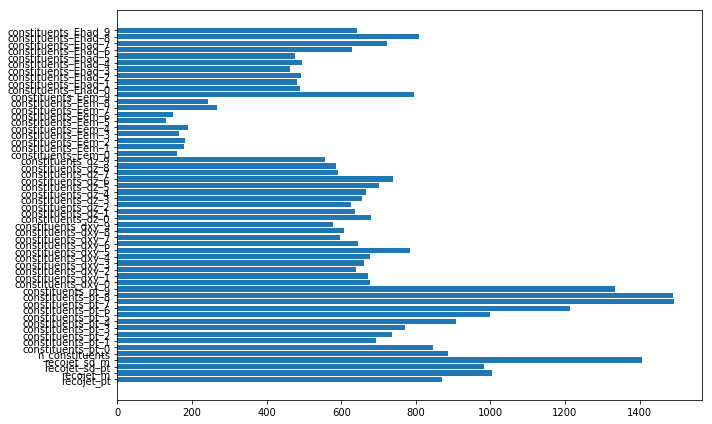

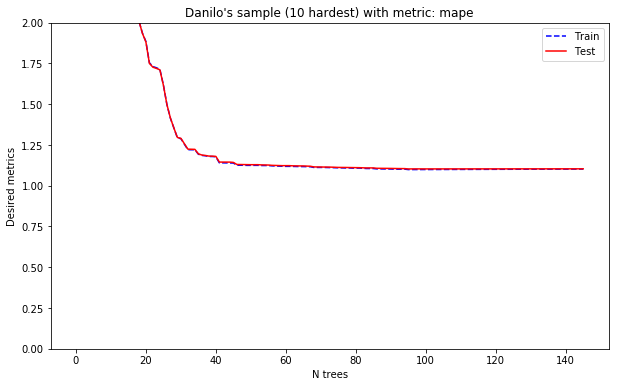

{'regression_l1': 0.701218519949128, 'mape': 1.1028085728701553}


In [36]:
objM = {}

for obj in ['regression_l1', 'mape']:
    print('========================================')
    print('================', obj,'=======================')
    print('========================================')
    clf.set_params(**{'objective': obj})
    print(clf.get_params()['objective'])
    clf.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_names=['validation_0', 'validation_1'],
            eval_metric=evaluate_loss_lgb,
            early_stopping_rounds=nEarlyStop, 
            verbose=100)

    objM[obj] = evaluate_loss(y_test, clf.predict(X_test))
    plt.figure(figsize=(10,6))
    plt.barh(clf.booster_.feature_name(), clf.booster_.feature_importance())
    plt.tight_layout()
    plt.show()
    plotClfPerfEvolution(clf, title='Danilo\'s sample (10 hardest) with metric: {}'.format(obj), nEarlyStop=nEarlyStop )
    plt.ylim((0,2))
    plt.show()
    
print(objM)

# Let's try the metric suggested by Danilo, as well as other custom metrics

In [25]:
def lossDanilo(y_true, y_pred):
    # The function itself is sum_entries ((y_pred - y_true)/(1 + y_pred + y_true))**2
    eps=1
    grad = 2 * (y_pred - y_true) * (eps + 2*y_true) / (eps + y_pred + y_true)**3
    hess = 2 * (eps + 2*y_true) / (eps + y_pred + y_true)**4 * (eps + 4*y_true - 2*y_pred)
    return (grad,hess)

In [26]:
def lossDaniloEps(y_true, y_pred):
    # The function itself is sum_entries ((y_pred - y_true)/(1 + y_pred + y_true))**2
    eps=1e-3
    grad = 2 * (y_pred - y_true) * (eps + 2*y_true) / (eps + y_pred + y_true)**3
    hess = 2 * (eps + 2*y_true) / (eps + y_pred + y_true)**4 * (eps + 4*y_true - 2*y_pred)
    return (grad,hess)

In [27]:
def lossRatio(y_true, y_pred):
    # The function itself is sum_entries ((y_pred - y_true)/y_true)**2
    eps=1e-5
    if(abs(y_true) > eps):
        grad = 2 * (y_pred - y_true) / y_true**2
        hess = 2 / y_true**2
    else:
        grad = 0
        hess = 0
    return (grad,hess)

In [32]:
def lossRatioEps(y_true, y_pred):
    # The function itself is sum_entries ((y_pred - y_true)/(1e-5 + y_true)**2
    eps=1e-3
    grad = 2 * (y_pred - y_true) / (eps+y_true)**2
    hess = 2 / (eps+y_true)**2
    return (grad,hess)

In [30]:
def lossRatioOne(y_true, y_pred):
    # The function itself is sum_entries ((y_pred - y_true)/(1e-5 + y_true)**2
    eps=1
    grad = 2 * (y_pred - y_true) / (eps+y_true)**2
    hess = 2 / (eps+y_true)**2
    return (grad,hess)

In [35]:
objM = {}
clf.set_params(**{'n_estimators': 1000})

for obj in [lossRatioOne, lossRatioEps, lossDanilo, lossDaniloEps]:
    print('========================================')
    print('================', obj.__name__,'=======================')
    print('========================================')
    clf.set_params(**{'objective': obj})

    clf.fit(X_train, y_train, 
            eval_set=[(X_test, y_test)],
            eval_names=['validation_1'],
            eval_metric=evaluate_loss_lgb,
            early_stopping_rounds=nEarlyStop*3, 
            verbose=100)

    objM[obj.__name__] = evaluate_loss(y_test, clf.predict(X_test))
    
print(objM)

================ lossRatioOne =======================
Training until validation scores don't improve for 150 rounds.
[100]	validation_1's xxx: 1.36896
[200]	validation_1's xxx: 1.26205
[300]	validation_1's xxx: 1.20693
[400]	validation_1's xxx: 1.16807
[500]	validation_1's xxx: 1.14094
[600]	validation_1's xxx: 1.12058
[700]	validation_1's xxx: 1.10654
[800]	validation_1's xxx: 1.09303
[900]	validation_1's xxx: 1.08194
[1000]	validation_1's xxx: 1.07197
Did not meet early stopping. Best iteration is:
[1000]	validation_1's xxx: 1.07197
================ lossRatioEps =======================
Training until validation scores don't improve for 150 rounds.
[100]	validation_1's xxx: 1.644
[200]	validation_1's xxx: 1.42254
[300]	validation_1's xxx: 1.35174
[400]	validation_1's xxx: 1.30437
[500]	validation_1's xxx: 1.2707
[600]	validation_1's xxx: 1.24237
[700]	validation_1's xxx: 1.21471
[800]	validation_1's xxx: 1.19658
[900]	validation_1's xxx: 1.18233
[1000]	validation_1's xxx: 1.17224
Did 

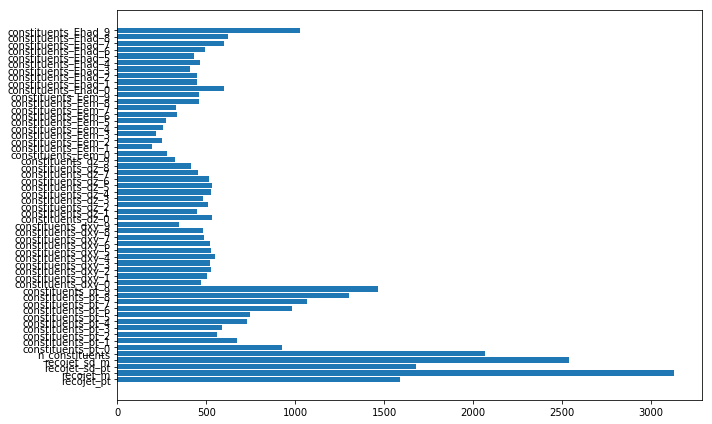

In [28]:
plt.figure(figsize=(10,6))
plt.barh(clf.booster_.feature_name(), clf.booster_.feature_importance())
plt.tight_layout()

In [25]:
evaluate_loss(y_test, clf.predict(X_test, num_iteration=78))

1.548779707305563

## Save the optimised clf object

In [ ]:
#joblib.dump(gs1, "gs1_2it.joblib.dat")

In [ ]:
param_test_list = [{'max_depth': [7, 9, 11],
               'min_child_weight': [1,3]},
               {'gamma': [0,1e-3,1e-1]},
               {'reg_alpha':[0, 1e-5],
               'reg_lambda':[1, 0.5,2]}]
clf.set_params(**xgb_opt_ref1)
for param_test in param_test_list:
    gs1 = GridSearchCV(estimator=clf, param_grid=param_test, 
                       scoring=make_scorer(evaluate_loss, greater_is_better=False),
                       n_jobs=4, cv=3,
                       verbose=True)
    gs1.fit(X_train, y_train)
    print(gs1.best_params_)
    print(gs1.best_score_)
    clf.set_params(**(gs1.best_params_))

## PCA train (no PCA-specific HP optimisation)

================ mse =======================
mse
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's l2: 6186.2	validation_0's xxx: 1.87755	validation_1's l2: 8036.67	validation_1's xxx: 2.01029
[200]	validation_0's l2: 4872.33	validation_0's xxx: 1.73434	validation_1's l2: 7702.85	validation_1's xxx: 1.94617
[300]	validation_0's l2: 4103.06	validation_0's xxx: 1.63516	validation_1's l2: 7628.49	validation_1's xxx: 1.91412
Early stopping, best iteration is:
[303]	validation_0's l2: 4092.38	validation_0's xxx: 1.63096	validation_1's l2: 7626.82	validation_1's xxx: 1.91306


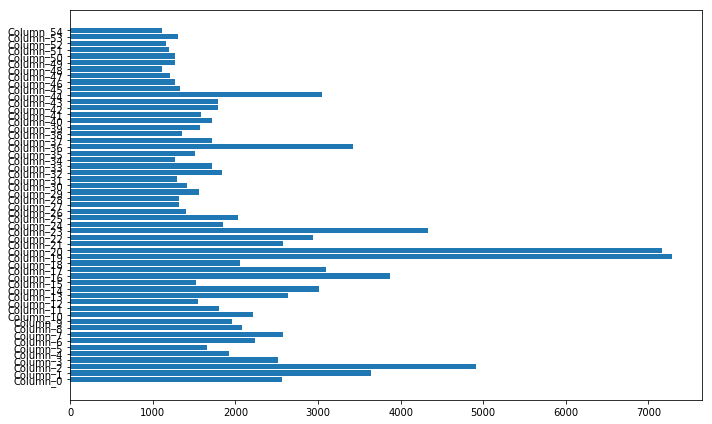

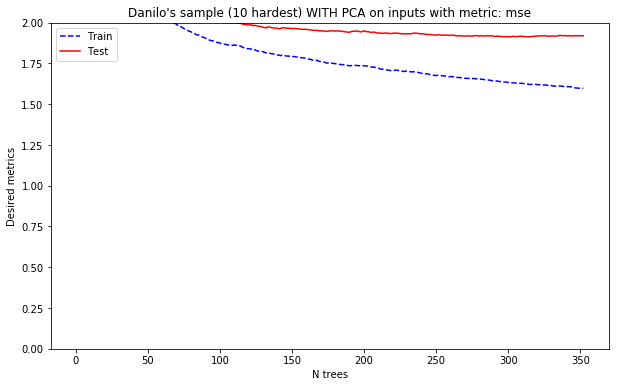

================ regression_l1 =======================
regression_l1
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's l1: 45.3313	validation_0's xxx: 1.08603	validation_1's l1: 48.8524	validation_1's xxx: 1.26438
[200]	validation_0's l1: 41.5574	validation_0's xxx: 0.987539	validation_1's l1: 46.4664	validation_1's xxx: 1.24865
Early stopping, best iteration is:
[179]	validation_0's l1: 42.1295	validation_0's xxx: 1.00165	validation_1's l1: 46.7864	validation_1's xxx: 1.24718


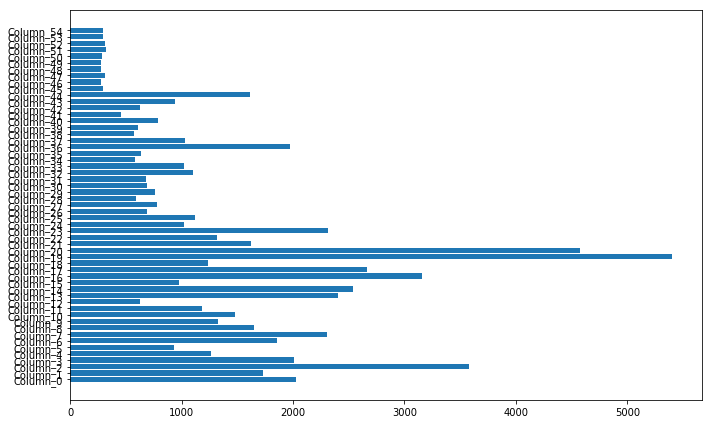

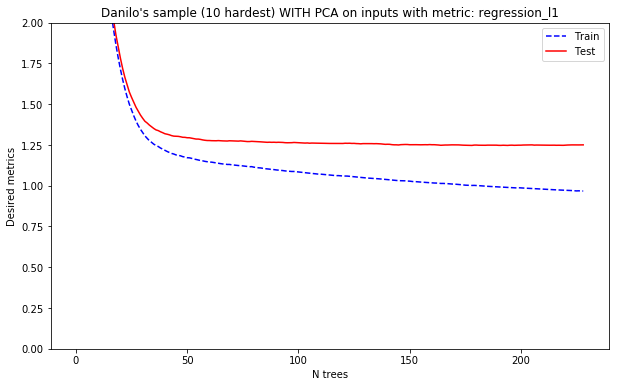

================ mape =======================
mape
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's mape: 0.733878	validation_0's xxx: 2.64969	validation_1's mape: 0.751003	validation_1's xxx: 2.59063
[200]	validation_0's mape: 0.724003	validation_0's xxx: 2.45101	validation_1's mape: 0.745158	validation_1's xxx: 2.3956
[300]	validation_0's mape: 0.720098	validation_0's xxx: 2.38303	validation_1's mape: 0.742878	validation_1's xxx: 2.32537
[400]	validation_0's mape: 0.717962	validation_0's xxx: 2.36566	validation_1's mape: 0.742186	validation_1's xxx: 2.30523
[500]	validation_0's mape: 0.716201	validation_0's xxx: 2.34046	validation_1's mape: 0.741511	validation_1's xxx: 2.27932
Did not meet early stopping. Best iteration is:
[500]	validation_0's mape: 0.716201	validation_0's xxx: 2.34046	validation_1's mape: 0.741511	validation_1's xxx: 2.27932


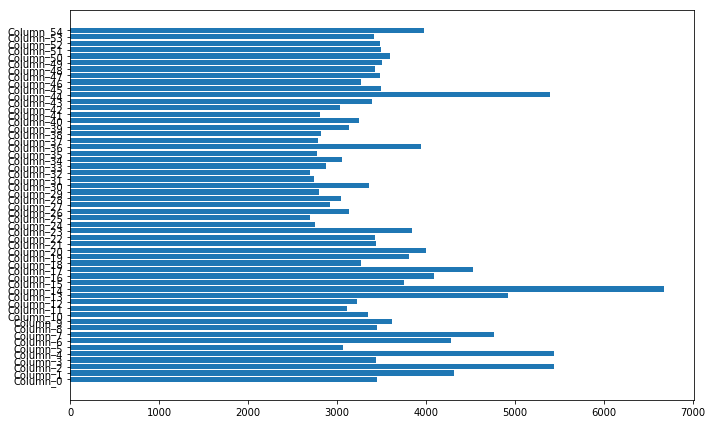

ValueError: x and y must have same first dimension, but have shapes (550,) and (500,)

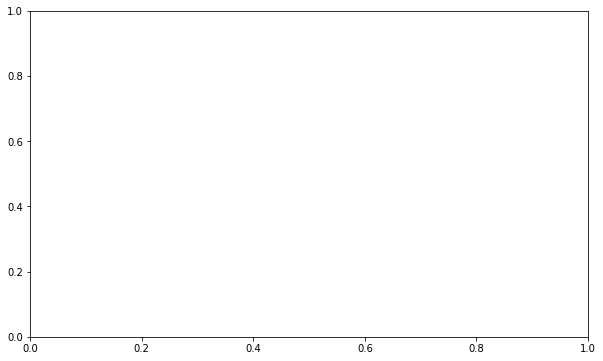

In [38]:
objM_pca = {}

for obj in ['mse', 'regression_l1', 'mape']:
    print('========================================')
    print('================', obj,'=======================')
    print('========================================')
    clf.set_params(**{'objective': obj})
    print(clf.get_params()['objective'])
    clf.fit(X_train_pca, y_train, 
            eval_set=[(X_train_pca, y_train), (X_test_pca, y_test)],
            eval_names=['validation_0', 'validation_1'],
            eval_metric=evaluate_loss_lgb,
            early_stopping_rounds=nEarlyStop, 
            verbose=100)

    objM_pca[obj] = evaluate_loss(y_test, clf.predict(X_test_pca))
    #do feature importance plot as reported by GBT
    plt.figure(figsize=(10,6))
    plt.barh(clf.booster_.feature_name(), clf.booster_.feature_importance())
    plt.tight_layout()
    plt.show()
    #Do Loss evolution plot
    plotClfPerfEvolution(clf, title='Danilo\'s sample (10 hardest) WITH PCA on inputs with metric: {}'.format(obj), nEarlyStop=nEarlyStop )
    plt.ylim((0,2))
    plt.show()
    
print(objM_pca)

In [ ]:
#joblib.dump(gs2, "gs2.joblib.dat")